In [2]:
import pandas as pd
import numpy as np
import math

df_vwc = pd.read_csv('/content/drive/Shareddrives/1st Paper/SSA/s11vwc.csv', header = 0)[['Trend', 'signal.detrend', 'Noise']].T.to_numpy()
df_stemp = pd.read_csv('/content/drive/Shareddrives/1st Paper/SSA/S11T.csv', header = 0)[['trend_total', 'signal.detrend', 'noise_Stage2']].T.to_numpy()
df_T = pd.read_csv('/content/drive/Shareddrives/1st Paper/SSA/T.csv', header = 0)[['trend_total', 'signal.detrend', 'noise_Stage2']].T.to_numpy()
df_RH = pd.read_csv('/content/drive/Shareddrives/1st Paper/SSA/RH.csv', header = 0)[['trend_total', 'signal.detrend', 'noise_Stage2']].T.to_numpy()
#df_DP = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_DP.npy', allow_pickle=True)
df_Rain = pd.read_csv('/content/drive/Shareddrives/1st Paper/SSA/R.csv', header = 0)[['trend_total', 'signal.detrend', 'noise_Stage2']].T.to_numpy()
df_WS = pd.read_csv('/content/drive/Shareddrives/1st Paper/SSA/WS.csv', header = 0)[['trend_total', 'signal.detrend', 'noise_Stage2']].T.to_numpy()
#df_WD = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_WD.npy', allow_pickle=True)
df_S = pd.read_csv('/content/drive/Shareddrives/1st Paper/SSA/SR.csv', header = 0)[['trend_total', 'signal.detrend', 'noise_Stage2']].T.to_numpy()

list_ = [df_vwc, df_Rain, df_stemp, df_T, df_RH,  df_WS, df_S]

# IMF = np.empty((10, 10, 10))
ssa = [[],[],[]]
# for i in list_:
#   print(i.shape)
for k in range(len(ssa)):
  for i in list_:
    ssa[k].append(i[k])


# df_vwc = pd.DataFrame(df_vwc).T
# df_vwc.columns = ['IMF1','IMF2','IMF3','IMF4','IMF5','IMF6','IMF7','IMF8','IMF9','IMF10','IMF11',
#               'IMF12','IMF13','IMF14', 'IMF15']

# df_stemp = pd.DataFrame(df_stemp).T
# df_stemp.columns = ['IMF1','IMF2','IMF3','IMF4','IMF5','IMF6','IMF7','IMF8','IMF9','IMF10','IMF11',
#               'IMF12','IMF13']

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.6 MB/s eta 0:00:00


In [4]:
##LSTM
import pandas as pd
import numpy as np
import math

import sklearn
import keras
import keras.backend as K
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM, CuDNNLSTM, MaxPooling1D, Conv1D, Flatten, BatchNormalization, Dropout, Input
from keras.models import Model
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping


from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from multiprocessing import cpu_count 
from joblib import Parallel 
from joblib import delayed 
from datetime import datetime

import optuna 

from sklearn.preprocessing import StandardScaler

from keras.utils import custom_object_scope
from keras.utils import get_custom_objects

from keras.layers import LSTM, RepeatVector, TimeDistributed, BatchNormalization, Dropout
from keras.initializers import GlorotUniform
from keras.activations import relu
from joblib import Parallel, delayed

import cProfile

# from warnings import catch_warnings 
# from warnings import filterwarnings

In [5]:
####################################################################################################
def nmse(y_true, y_pred):
    """
    Calculate the normalized mean squared error (NMSE) between y_true and y_pred.
    """
    return np.mean(np.square(y_pred - y_true)) / np.var(y_true)
####################################################################################################
def smape(y_true, y_pred):
    """
    Calculate the Symmetric Mean Absolute Percentage Error (SMAPE) between y_true and y_pred.
    """
    return np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100
####################################################################################################
def smase(y_true, y_pred, y_naive):
    """
    Calculate the Symmetric Mean Absolute Scaled Error (sMASE) between y_true and y_pred, relative 
    to a symmetric naive forecast y_naive.
    """
    # Calculate the symmetric naive forecast
    y_sym_naive = (y_naive.shift(1) + y_naive.shift(-1)) / 2.0
    
    # Calculate the MAPE of the forecast relative to the symmetric naive forecast
    mape_forecast = np.mean(np.abs(y_pred - y_sym_naive) / np.abs(y_true - y_sym_naive))
    
    # Calculate the MAPE of the historical data relative to the same symmetric naive forecast
    mape_historical = np.mean(np.abs(y_true - y_sym_naive.shift(1)) / np.abs(y_true - y_sym_naive))
    
    return mape_forecast / mape_historical
####################################################################################################
def nse(y_true, y_pred):
    """
    Calculate the Nash-Sutcliffe Efficiency (NSE) between y_true and y_pred.
    """
    mse = mean_squared_error(y_true, y_pred)
    rss = mse * len(y_true)
    tss = mean_absolute_error(y_true, np.mean(y_true)) ** 2 * len(y_true)
    return 1 - (rss / tss)
#####################################################################################################
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Register the custom metric function with Keras
with custom_object_scope({'r2_keras': r2_keras}):
    get_custom_objects().update({'r2_keras': r2_keras})

In [6]:


##Encoder/Decoder LSTM with Multivariate Input

#Splitting datasets into train/test set

def split_dataset(data):
  # split into standard weeks
  train, test = data[1:-6046], data[-6048:]
  #train, test = data[:-5817], data[-5817:-57]
  # restructure into windows of weekly data
  train = np.array(np.split(train, len(train)/144))
  test = np.array(np.split( test , len(test )/144))
  return train, test

def rmse_(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

def nmse(actual, predicted):
    return mean_squared_error(actual, predicted) / np.var(actual)

def smape(actual, predicted):
    return 100 / len(actual) * np.sum(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

def nse(actual, predicted):
    return 1 - np.sum((actual - predicted) ** 2) / np.sum((actual - np.mean(actual)) ** 2)

def r2(y_true, y_pred):
    SS_res =  np.sum(K.square(y_true - y_pred))
    SS_tot =  np.sum(K.square(y_true - np.mean(y_true)))
    return 1 - SS_res/(SS_tot + np.finfo(float).eps) 

def compute_scores(actual, predicted):
    rmse_score = rmse_(actual, predicted)
    nmse_score = nmse(actual, predicted)
    smape_score = smape(actual, predicted)
    nse_score = nse(actual, predicted)
    r2_score = r2(actual, predicted)
    return rmse_score, nmse_score, smape_score, nse_score, r2_score

def evaluate_forecasts(actual, predicted):
    # rmse_scores = [rmse_(actual[:, i],   predicted[:, i])      for i in  range(actual.shape[1])]
    # nmse_scores = [nmse(actual[:, i],    predicted[:, i])      for i in  range(actual.shape[1])]
    # smape_scores = [smape(actual[:, i],  predicted[:, i])      for i in  range(actual.shape[1])]
    # nse_scores = [nse(actual[:, i],      predicted[:, i])      for i in  range(actual.shape[1])]
    # r2_scores = [r2(actual[:,i],   predicted[:, i])      for i in  range(actual.shape[1])]
    # parallelize the loop using joblib

    rmse_scores, nmse_scores, smape_scores, nse_scores, r2_scores = zip(*Parallel(n_jobs=-1)(
    delayed(compute_scores)(actual[:, i], predicted[:, i]) for i in range(actual.shape[1])))

    overall_rmse = rmse_(actual, predicted.reshape(predicted.shape[0],predicted.shape[1]))
    overall_nmse = nmse(actual, predicted.reshape(predicted.shape[0],predicted.shape[1]))
    overall_smape = smape(actual, predicted.reshape(predicted.shape[0],predicted.shape[1]))
    overall_nse = nse(actual, predicted.reshape(predicted.shape[0],predicted.shape[1]))
    overall_r2 = r2(actual, predicted.reshape(predicted.shape[0],predicted.shape[1]))
    return overall_rmse,overall_nmse, overall_smape, overall_nse, overall_r2, rmse_scores, nmse_scores, smape_scores, nse_scores, r2_scores

#####################################################################################################
#summarize scores
def summarize_scores(name, score, scores):
  s_scores = ', '.join(['%.1f' % s for s in scores])
  print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs


def to_supervised(train, n_input, n_out=144):
  #flattern data
  data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for i in range(len(data)):
    #define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    #ensure there is enough data
    if out_end <= len(data):
      X.append(data[in_start:in_end, :])
      y.append(data[in_end:out_end, 0])
    # move along one time step
    in_start += 1
  return np.array(X), np.array(y)
 
# #train the model LSTM-ED

def build_model(train, config, verbose):
  # Unpack config
  n_input, n_nodes, n_epochs, n_batch = config
  # prepare data
  train_x, train_y = to_supervised(train, n_input)
  # Parameters
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
  # reshape output into [samples, timesteps, features]
  train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
  
  #define model
  
  # define model input
  inputs = Input(shape=(n_timesteps, n_features))
  
  # encoder layers
  encoder = CuDNNLSTM(n_nodes)(inputs)
  encoder = RepeatVector(n_outputs)(encoder)
  
  # decoder layers
  decoder = CuDNNLSTM(n_nodes, return_sequences=True)(encoder)
  decoder = TimeDistributed(Dense(n_nodes/2))(decoder)
  decoder = TimeDistributed(Dense(1))(decoder)

  # define model
  model = Model(inputs=inputs, outputs=decoder)

  model.compile(loss='mae', optimizer='adam',  metrics= ['MeanAbsoluteError', 'MeanSquaredError', 'mean_absolute_percentage_error', 'r2_keras'])
  
  # fit network
  model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose= verbose)
  plt.plot(model.history.history['loss'])
  plt.title('Training Metrics')
  plt.ylabel('Value')
  plt.xlabel('Epoch')
  plt.legend(['loss'], loc='upper right')
  plt.show()
  plt.clf()
  plt.plot(model.history.history['mean_absolute_error'])
  plt.plot(model.history.history['mean_squared_error'])
  plt.title('Training Metrics')
  plt.ylabel('Value')
  plt.xlabel('Epoch')
  plt.legend(['mean_absolute_error', 'mean_squared_error'], loc='upper right')
  plt.show()
  plt.clf()
  plt.plot(model.history.history['mean_absolute_percentage_error'])
  plt.title('Training Metrics')
  plt.ylabel('Value')
  plt.xlabel('Epoch')
  plt.legend(['mean_absolute_percentage_error'], loc='upper right')
  plt.show()
  plt.clf()
  plt.plot(model.history.history['r2_keras'])
  #plt.plot(model.history.history[])
  plt.title('Training Metrics')
  plt.ylabel('Value')
  plt.xlabel('Epoch')
  plt.legend(['r2_score'], loc='upper right')
  plt.show()
  return model

#forecast

def forecast(model, history, config):
  # unpack config
  n_input, _, _, _ = config
  #flattern data
  data = np.array(history)
  data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  #retrieve last observations for input data
  input_x = data[-n_input:, :]
  # reshape into [1, n_input, n]
  input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
  #forecast the next week
  yhat = model.predict(input_x, verbose=0)
  # we only want the vector forecast
  yhat = yhat
  return yhat

#evaluate a single model

def evaluate_model(train, test, cfg, verbose):
  #fit model
  model= build_model(train, cfg, verbose)
  #test = X_scaler.transform(test)
  # history is a list of n_input data
  history = [x for x in train]
  #walk_forward validation over each week
  predictions = list()
  for i in range(len(test)):
    #predict the week
    yhat_sequence = forecast(model, history, cfg)[0]
    #store the predictions
    predictions.append(yhat_sequence)
    #get real observation an add to history for predicting the next week
    history.append(test[i, :])
  #evaluate predictions hours for each n_input
  predictions = np.array(predictions)
  #overall_rmse,overall_nmse, overall_smape, overall_nse, rmse_scores, nmse_scores, smape_scores, nse_scores
  overall_rmse,overall_nmse, overall_smape, overall_nse, overall_r2, rmse_scores, nmse_scores, smape_scores, nse_scores, r2_scores = evaluate_forecasts(test[:, :, 0], predictions)
  return overall_rmse,overall_nmse, overall_smape, overall_nse, overall_r2, rmse_scores, nmse_scores, smape_scores, nse_scores, r2_scores, predictions, model

#Repeat evaluate

def repeat_evaluate(train, test, config, verbose, n_repeats=2):
  # Convert config to a key
  key = str(config)
  # fit and evaluate the model n times
  overall_rmse,overall_nmse, overall_smape, overall_nse, overall_r2, rmse_scores, nmse_scores, smape_scores, nse_scores, r2_scores, predictions, model = evaluate_model(train, test, config, verbose)
  overall_rmse_models = [overall_rmse for _ in range(n_repeats)]
  overall_nmse_models = [overall_nmse for _ in range(n_repeats)]
  overall_smape_models = [overall_smape for _ in range(n_repeats)]
  overall_nse_models = [overall_nse for _ in range(n_repeats)]
  overall_r2_models = [overall_r2 for _ in range(n_repeats)]
  # Sumarize score
  result_rmse =  np.mean(overall_rmse_models)
  result_nmse =  np.mean(overall_nmse_models)
  result_smape = np.mean(overall_smape_models)
  result_nse =   np.mean(overall_nse_models)
  result_r2 =    np.mean(overall_r2_models)
  #print('> Model[%s] %.3f' % (key, result))
  return (key, result_rmse, result_nmse, result_smape, result_nse, result_r2), predictions

# grid_search configs

def grid_search(train, test, cfg_list, verbose):
  #evaluate configs
  pack = [repeat_evaluate(train, test, cfg, verbose) for cfg in cfg_list]
  #sort config by error, asc
  scores = [item[0] for item in pack]
  predictions = [item[1] for item in pack]
  scores.sort(key=lambda tup: tup[1])
  return scores, predictions


def model_configs():
  n_input = [200]
  n_nodes = [200]
  n_epochs = [250]
  n_batch = [10]
  configs = list()
  for i in n_input:
    for j in n_nodes:
      for k in n_epochs:
        for l in n_batch:
          cfg = [i, j, k , l]
          configs.append(cfg)
  print('Total configs: %d' % len(configs))
  return configs

In [7]:
# define the objective function
def objective(trial):

    # specify the hyperparameters to optimize
    n_input = trial.suggest_int('n_input', 1, 144)
    n_nodes = trial.suggest_int('n_nodes', 32, 256)
    n_epochs = trial.suggest_int('n_epochs', 10, 100)
    n_batch = trial.suggest_int('n_batch', 16, 128)
    
    # split the data into training and testing sets
    train, test = split_dataset(df_s.values)
    #train = df_s.values

    # split the training data into folds for walk-forward validation
    n_splits = 5
    fold_size = int(len(train) / n_splits)
    folds = [train[i:i+fold_size] for i in range(0, len(train), fold_size)]
    
    # build the model using the hyperparameters
    model = build_model(train, (n_input, n_nodes, n_epochs, n_batch), verbose=False)
    
    
    # train and evaluate the model using walk-forward validation
    val_losses = []
    for i in range(n_splits):
        # prepare data for this fold
        train_x, train_y = to_supervised(np.concatenate(folds[:i] + folds[i+1:]), n_input)
        val_x, val_y = to_supervised(folds[i], n_input)
        train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
        val_y = val_y.reshape((val_y.shape[0], val_y.shape[1], 1))
        
        # train the model using early stopping
        es = EarlyStopping(monitor='val_loss', patience=10)
        history = model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, validation_data=(val_x, val_y), verbose=False, callbacks=[es])
        
        # evaluate the model on the validation set for this fold
        val_loss = history.history['val_loss'][-1]
        val_losses.append(val_loss)

        # metrics on validation set for this fold
        #al_mae = history.history['mean_absolute_error'][-1]
        #val_mse = history.history['mean_squared_error'][-1]
    
    # return the mean validation loss across all folds
    return np.mean(val_losses)

IMF:  0
CPU times: user 14 µs, sys: 2 µs, total: 16 µs
Wall time: 21.2 µs
Scale_: [0.05333779 0.45958054 0.59696625 0.90858732 0.94264763 0.89602207]


[I 2023-03-31 02:37:36,078] A new study created in RDB with name: no-name-9edbeb96-7005-4b31-bfb6-371d5f59f344


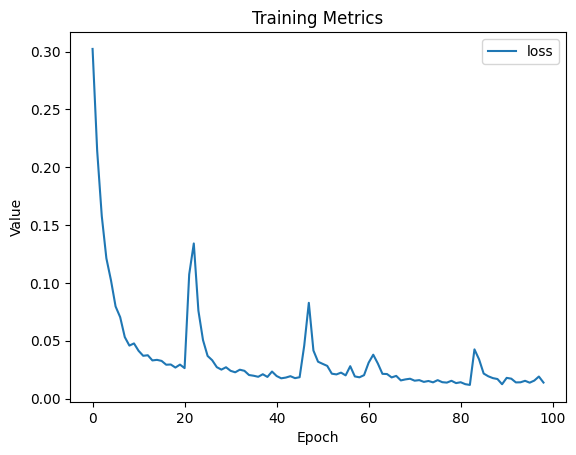

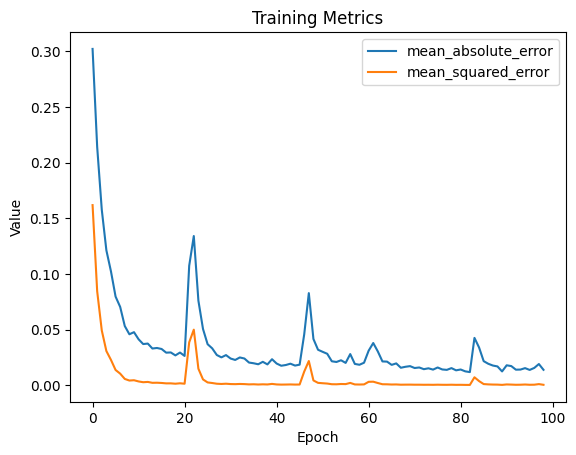

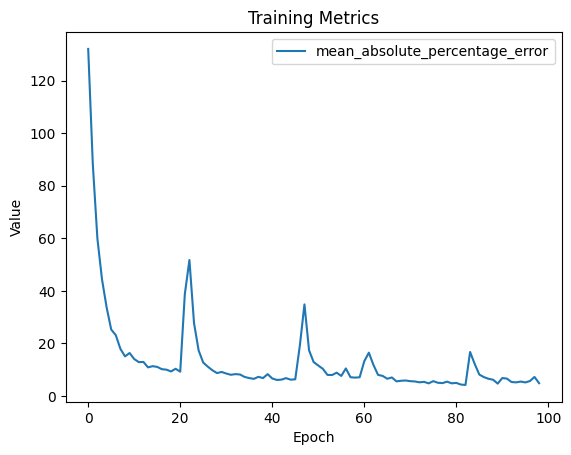

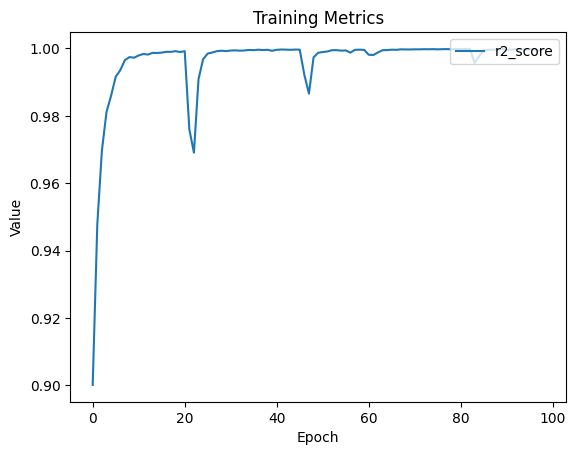

[I 2023-03-31 02:48:16,837] Trial 0 finished with value: 0.031008143723011018 and parameters: {'n_input': 93, 'n_nodes': 178, 'n_epochs': 99, 'n_batch': 126}. Best is trial 0 with value: 0.031008143723011018.


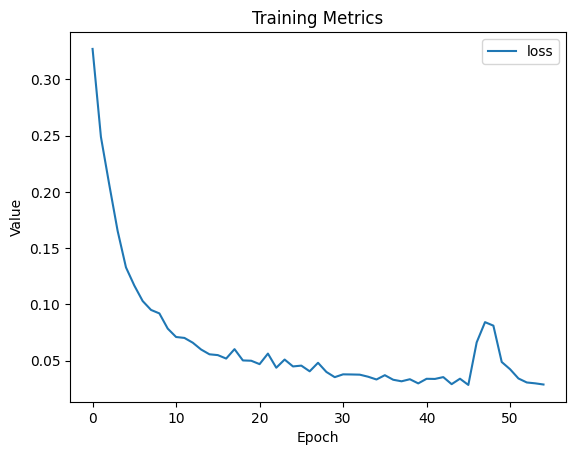

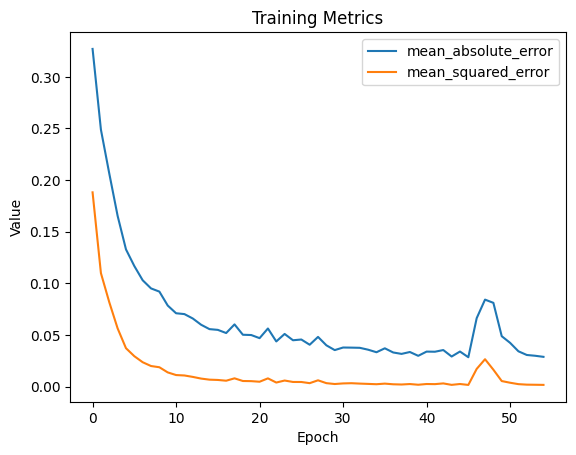

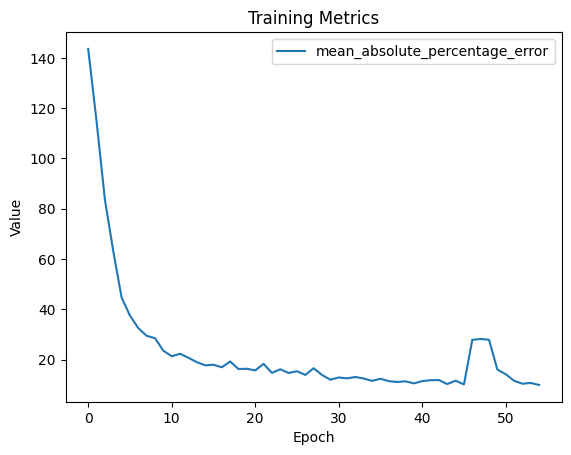

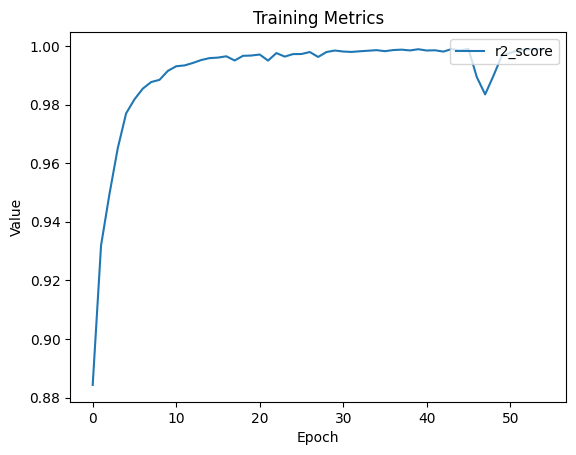

[I 2023-03-31 02:51:11,642] Trial 1 finished with value: 0.05142874717712402 and parameters: {'n_input': 59, 'n_nodes': 38, 'n_epochs': 55, 'n_batch': 116}. Best is trial 0 with value: 0.031008143723011018.


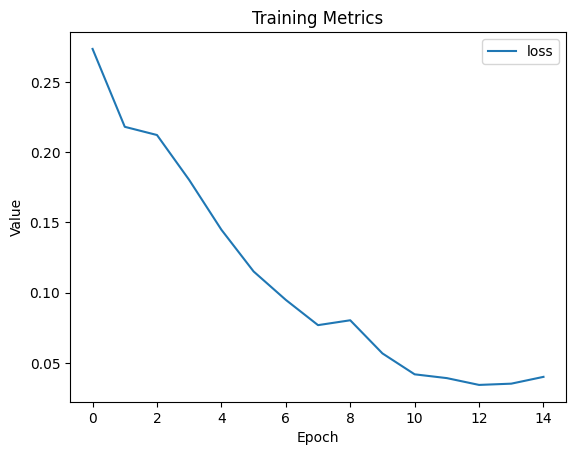

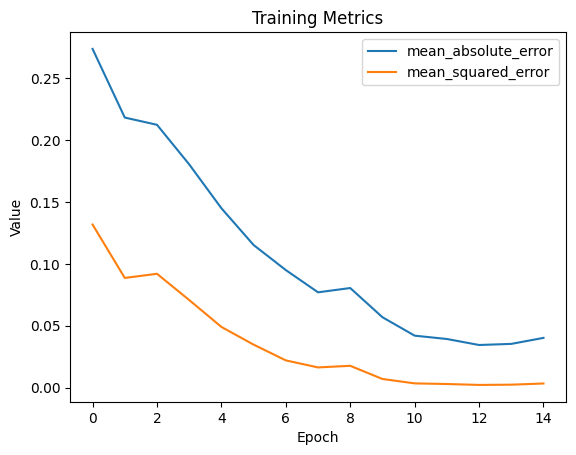

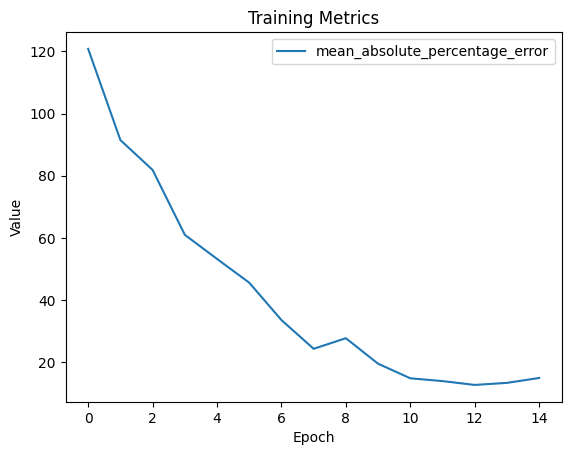

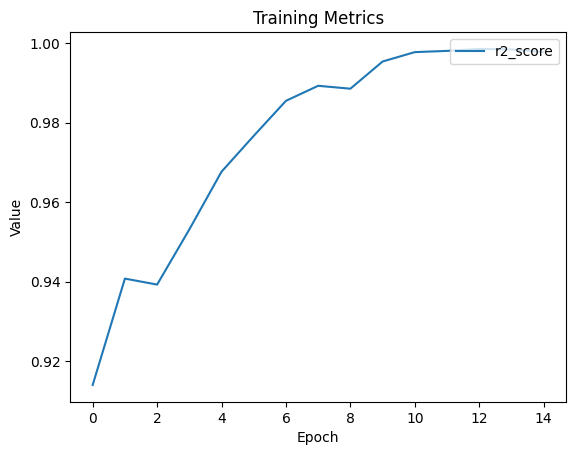

[I 2023-03-31 03:01:34,143] Trial 2 finished with value: 0.04900584816932678 and parameters: {'n_input': 107, 'n_nodes': 97, 'n_epochs': 15, 'n_batch': 24}. Best is trial 0 with value: 0.031008143723011018.


Best hyperparameters: {'n_batch': 126, 'n_epochs': 99, 'n_input': 93, 'n_nodes': 178}
Epoch 1/99
143/143 [==============================] - 8s 28ms/step - loss: 0.3022 - mean_absolute_error: 0.3022 - mean_squared_error: 0.1599 - mean_absolute_percentage_error: 126.6615 - r2_keras: 0.9019
Epoch 2/99
143/143 [==============================] - 4s 27ms/step - loss: 0.2038 - mean_absolute_error: 0.2038 - mean_squared_error: 0.0780 - mean_absolute_percentage_error: 81.2299 - r2_keras: 0.9520
Epoch 3/99
143/143 [==============================] - 4s 28ms/step - loss: 0.1503 - mean_absolute_error: 0.1503 - mean_squared_error: 0.0457 - mean_absolute_percentage_error: 55.4334 - r2_keras: 0.9718
Epoch 4/99
143/143 [==============================] - 4s 28ms/step - loss: 0.1178 - mean_absolute_error: 0.1178 - mean_squared_error: 0.0303 - mean_absolute_percentage_error: 41.3139 - r2_keras: 0.9814
Epoch 5/99
143/143 [==============================] - 4s 28ms/step - loss: 0.0970 - mean_absolute_error: 

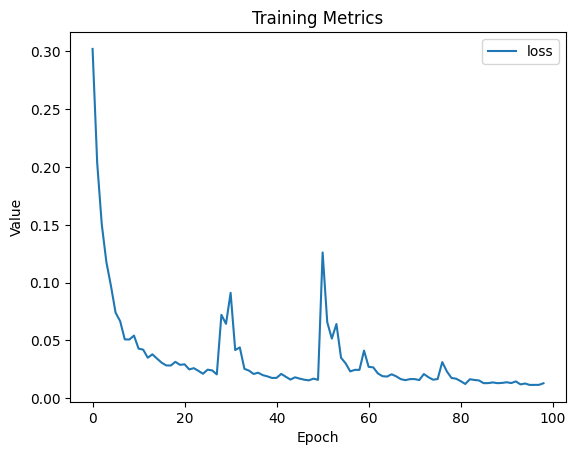

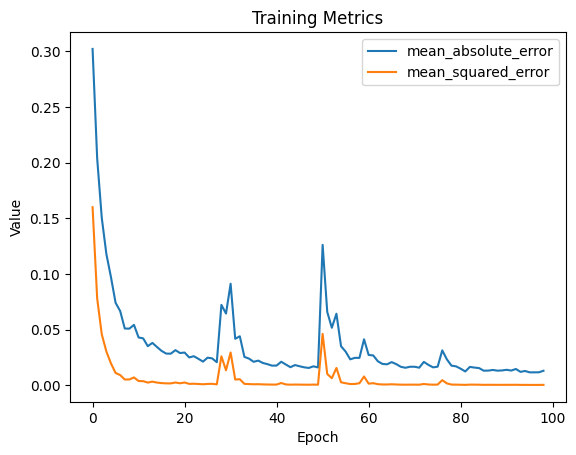

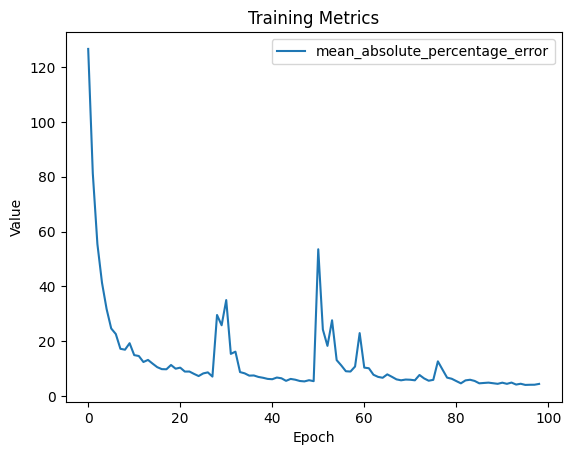

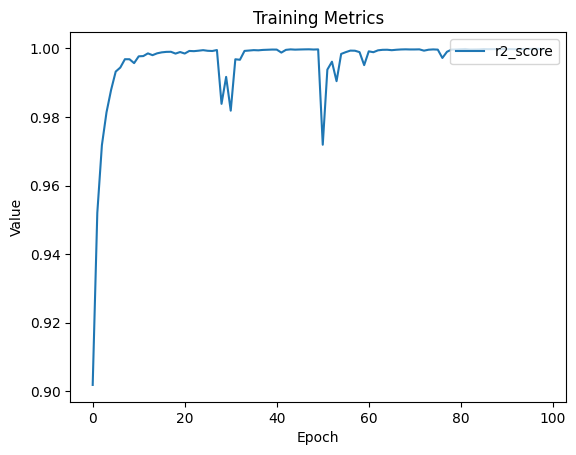

IMF:  1


[I 2023-03-31 03:09:13,450] A new study created in RDB with name: no-name-d4c176b5-a0ca-450f-8476-5cc84f229c93


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
Scale_: [0.10577994 0.95793695 0.79257864 0.79027109 0.79057888 0.16606185]


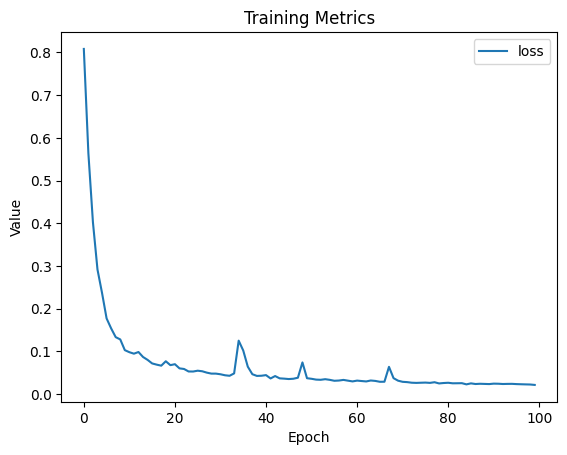

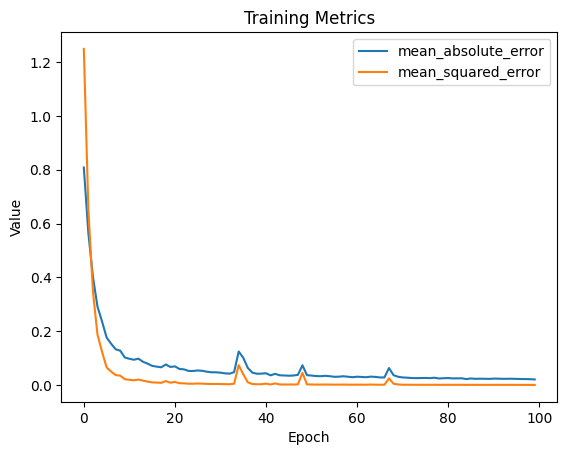

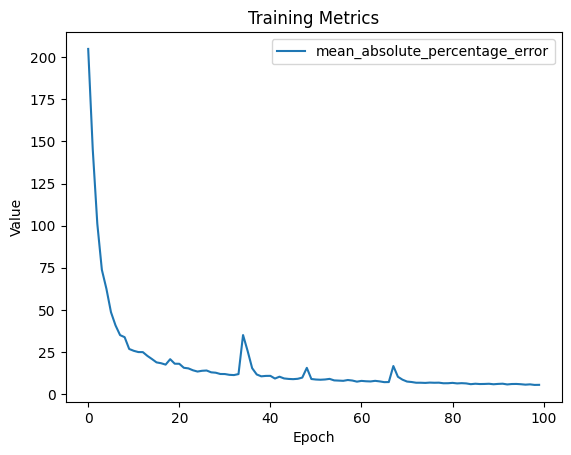

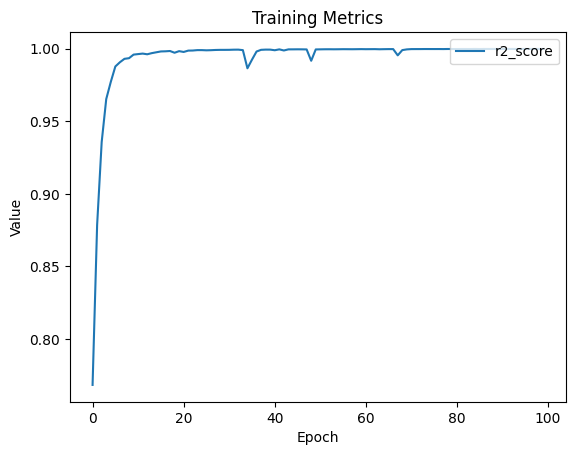

[I 2023-03-31 03:28:23,156] Trial 0 finished with value: 0.1045815296471119 and parameters: {'n_input': 88, 'n_nodes': 253, 'n_epochs': 100, 'n_batch': 62}. Best is trial 0 with value: 0.1045815296471119.


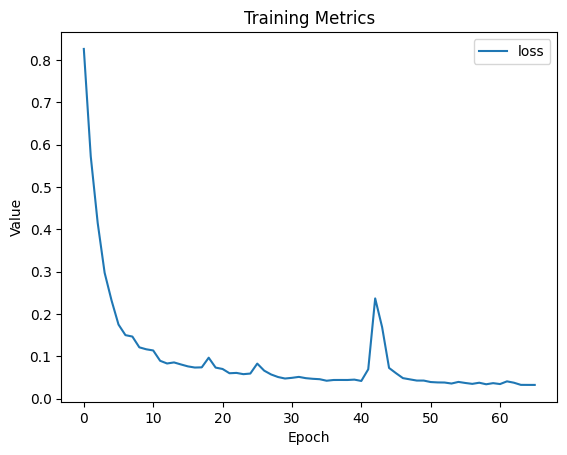

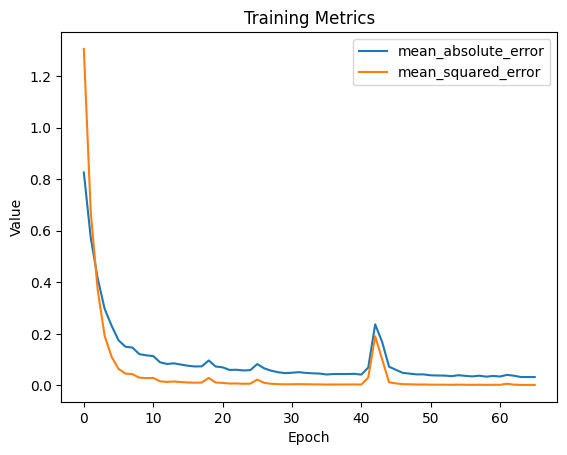

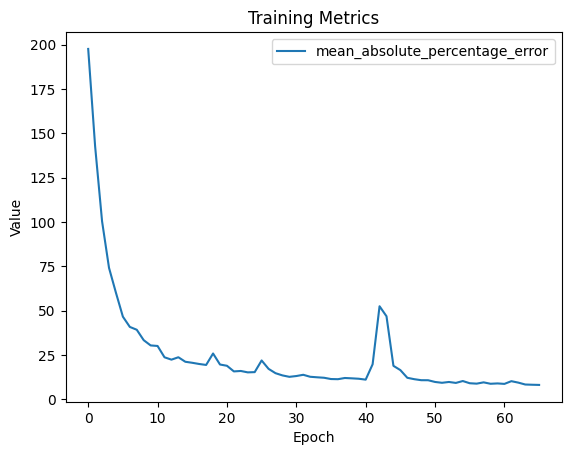

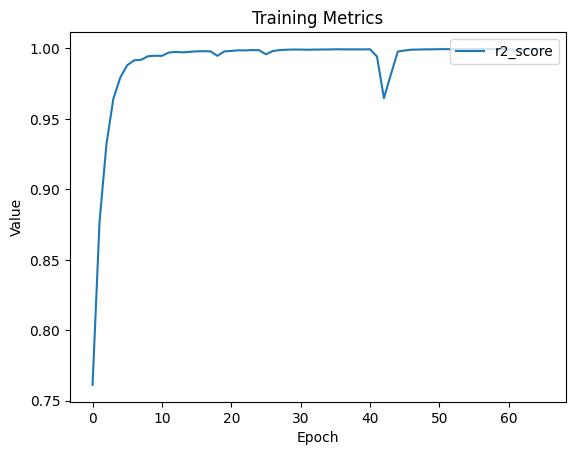

[I 2023-03-31 03:39:03,815] Trial 1 finished with value: 0.15384291410446166 and parameters: {'n_input': 100, 'n_nodes': 167, 'n_epochs': 66, 'n_batch': 79}. Best is trial 0 with value: 0.1045815296471119.


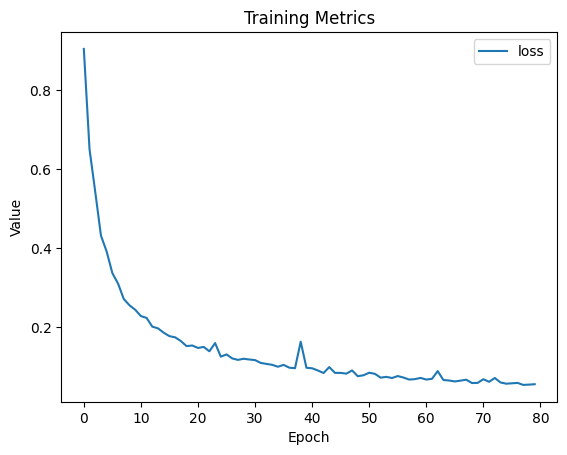

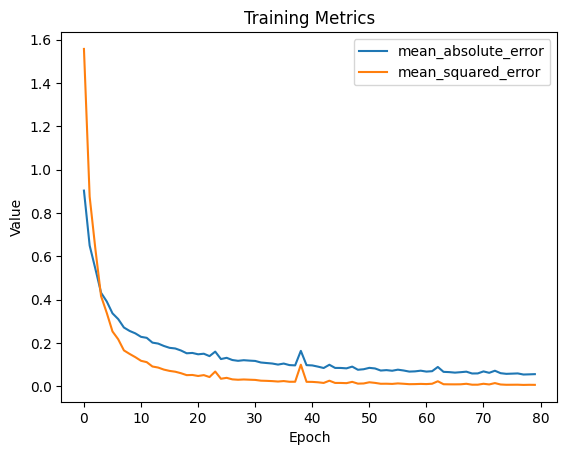

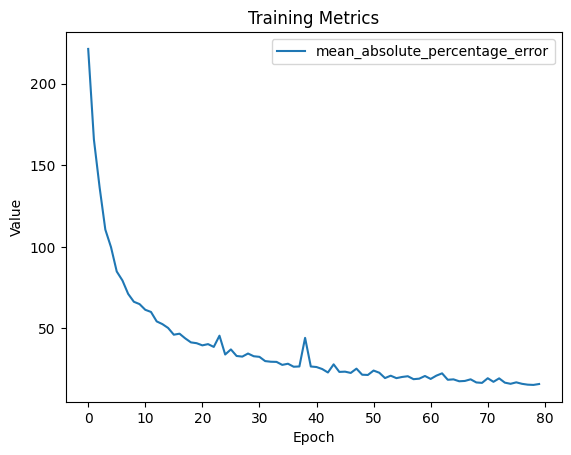

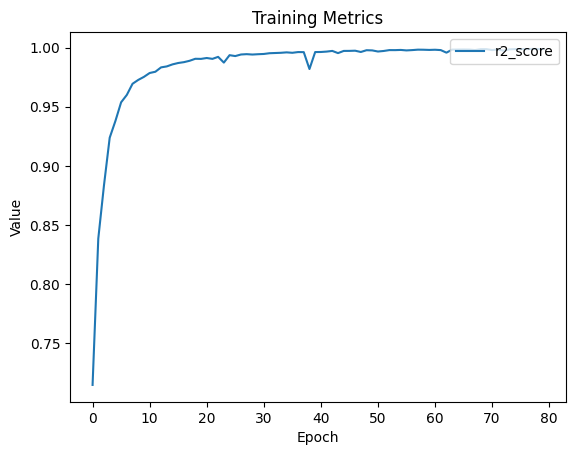

[I 2023-03-31 03:46:11,939] Trial 2 finished with value: 0.25800578743219377 and parameters: {'n_input': 37, 'n_nodes': 47, 'n_epochs': 80, 'n_batch': 73}. Best is trial 0 with value: 0.1045815296471119.


Best hyperparameters: {'n_batch': 62, 'n_epochs': 100, 'n_input': 88, 'n_nodes': 253}
Epoch 1/100
289/289 [==============================] - 10s 24ms/step - loss: 0.8256 - mean_absolute_error: 0.8256 - mean_squared_error: 1.3084 - mean_absolute_percentage_error: 210.6806 - r2_keras: 0.7568
Epoch 2/100
289/289 [==============================] - 7s 23ms/step - loss: 0.5995 - mean_absolute_error: 0.5995 - mean_squared_error: 0.7380 - mean_absolute_percentage_error: 154.3407 - r2_keras: 0.8630
Epoch 3/100
289/289 [==============================] - 7s 24ms/step - loss: 0.3996 - mean_absolute_error: 0.3996 - mean_squared_error: 0.3481 - mean_absolute_percentage_error: 97.9342 - r2_keras: 0.9357
Epoch 4/100
289/289 [==============================] - 7s 23ms/step - loss: 0.2986 - mean_absolute_error: 0.2986 - mean_squared_error: 0.1933 - mean_absolute_percentage_error: 76.2398 - r2_keras: 0.9639
Epoch 5/100
289/289 [==============================] - 7s 24ms/step - loss: 0.2251 - mean_absolute_

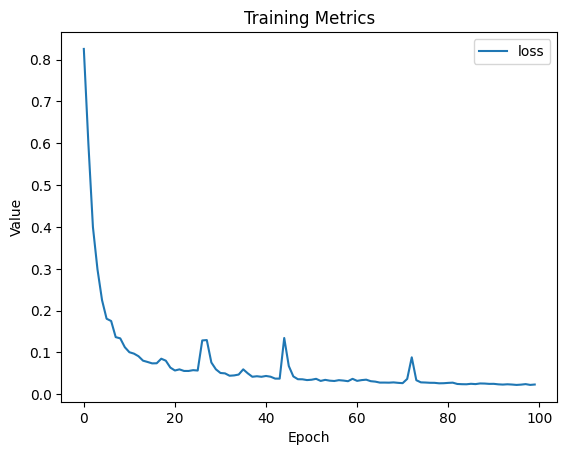

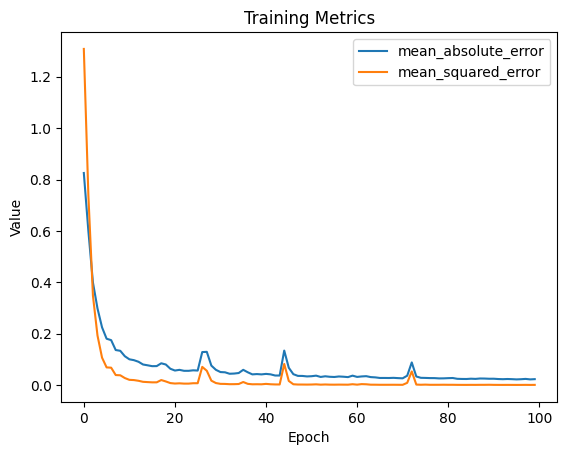

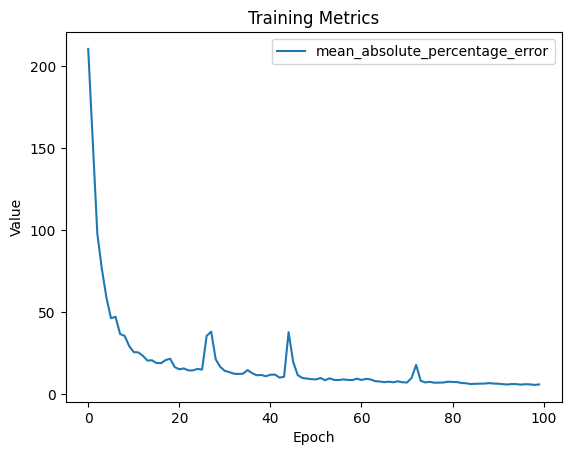

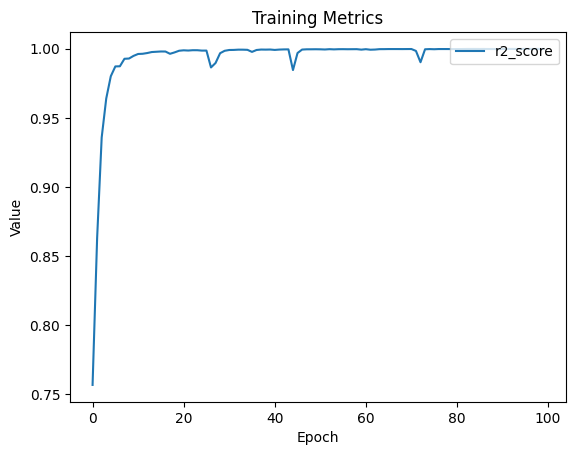

IMF:  2


[I 2023-03-31 03:57:37,822] A new study created in RDB with name: no-name-d426462a-c905-4dc5-b633-b6f5de5d0f88


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs
Scale_: [0.99452068 0.06346081 0.0603335  0.74152791 0.73623446 0.45504398]


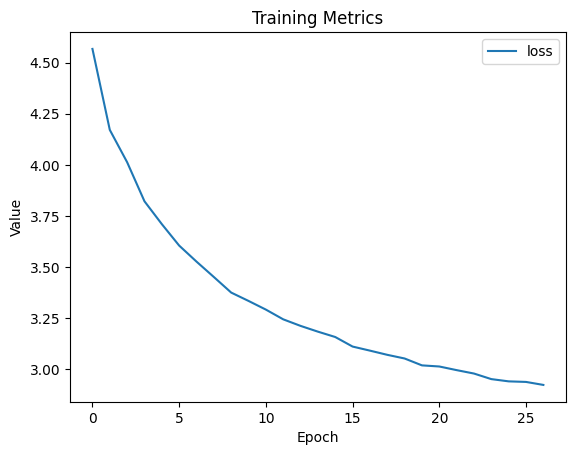

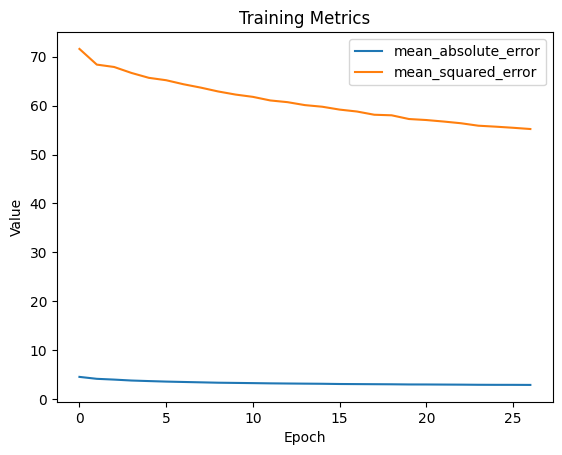

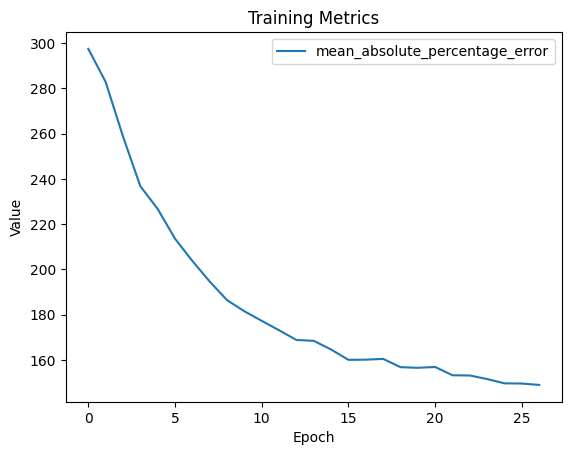

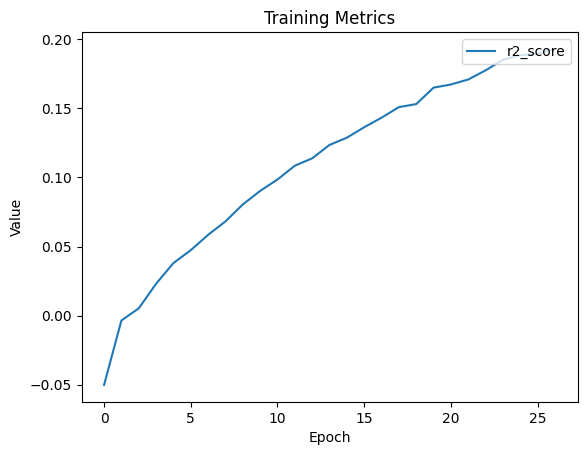

[I 2023-03-31 04:00:46,124] Trial 0 finished with value: 3.226302146911621 and parameters: {'n_input': 30, 'n_nodes': 75, 'n_epochs': 27, 'n_batch': 126}. Best is trial 0 with value: 3.226302146911621.


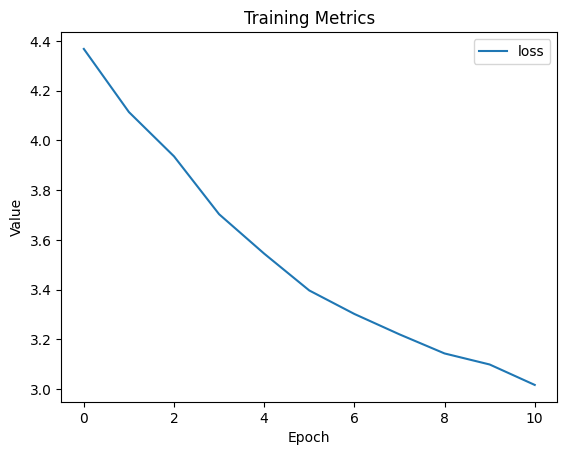

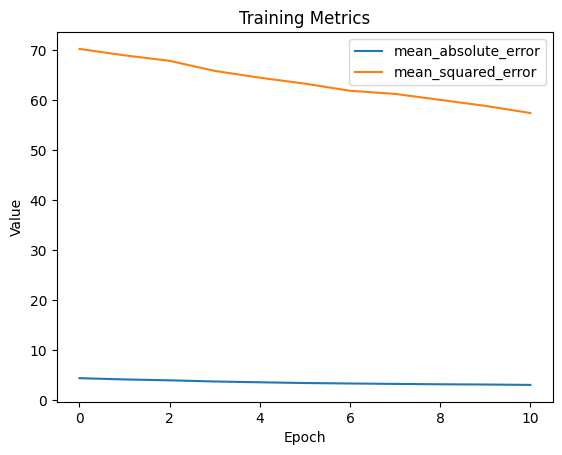

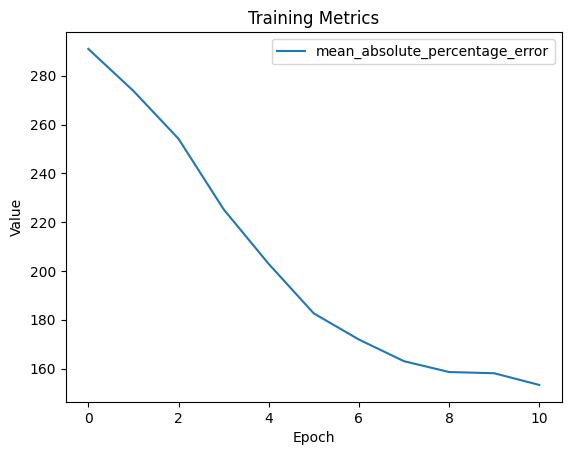

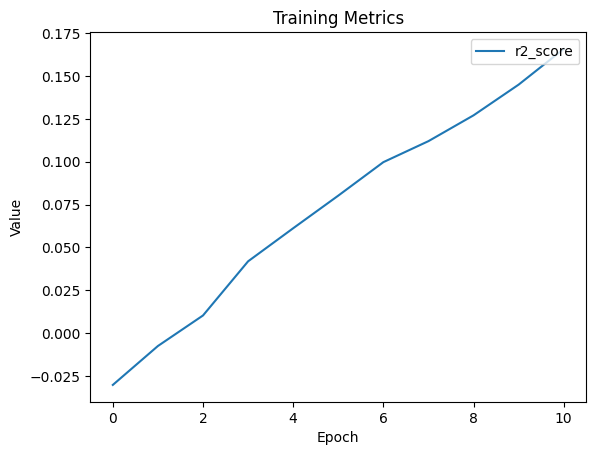

[I 2023-03-31 04:04:45,623] Trial 1 finished with value: 3.314259910583496 and parameters: {'n_input': 36, 'n_nodes': 162, 'n_epochs': 11, 'n_batch': 70}. Best is trial 0 with value: 3.226302146911621.


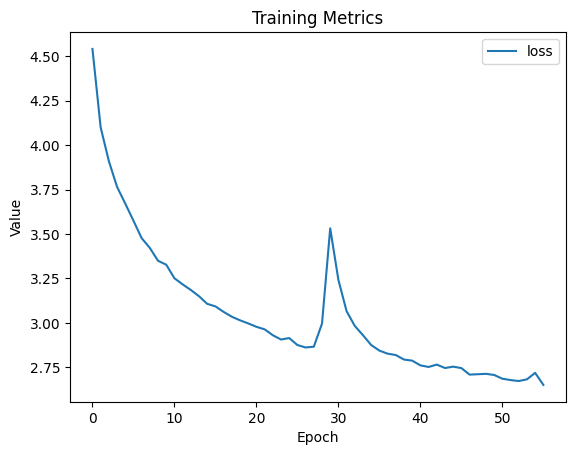

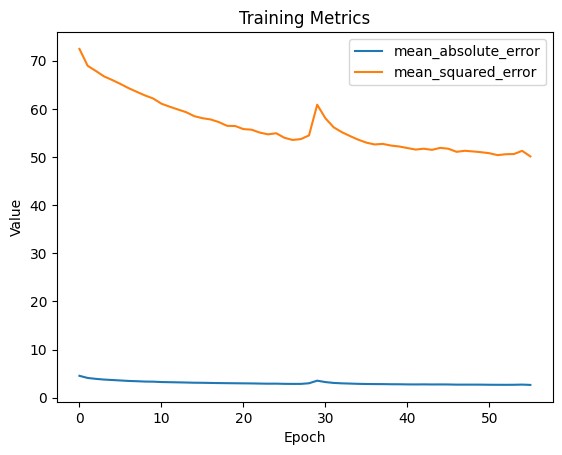

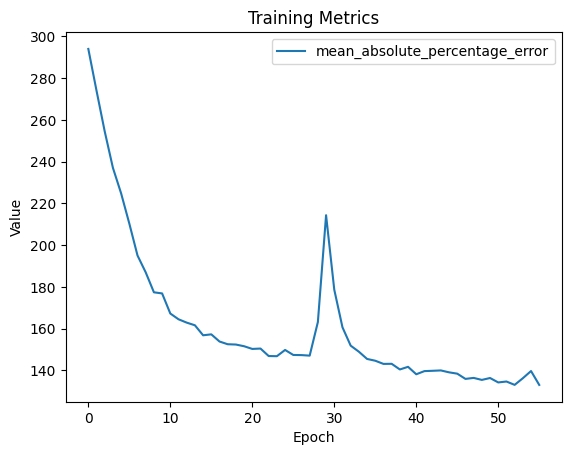

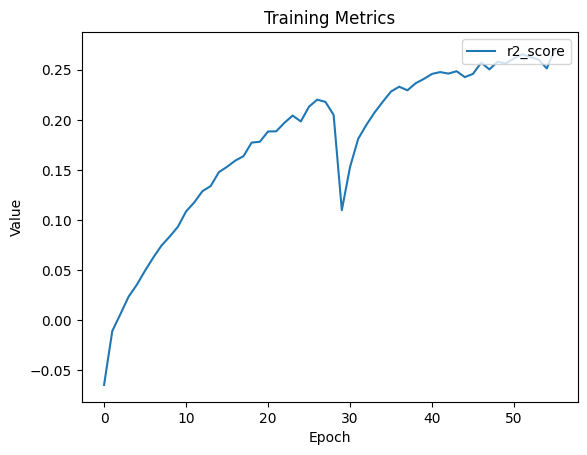

[I 2023-03-31 04:09:06,969] Trial 2 finished with value: 3.098509693145752 and parameters: {'n_input': 41, 'n_nodes': 72, 'n_epochs': 56, 'n_batch': 99}. Best is trial 2 with value: 3.098509693145752.


Best hyperparameters: {'n_batch': 99, 'n_epochs': 56, 'n_input': 41, 'n_nodes': 72}
Epoch 1/56
182/182 [==============================] - 5s 13ms/step - loss: 4.4956 - mean_absolute_error: 4.4956 - mean_squared_error: 71.9621 - mean_absolute_percentage_error: 291.8968 - r2_keras: -0.0573
Epoch 2/56
182/182 [==============================] - 2s 12ms/step - loss: 4.1403 - mean_absolute_error: 4.1403 - mean_squared_error: 68.9706 - mean_absolute_percentage_error: 282.2433 - r2_keras: -0.0116
Epoch 3/56
182/182 [==============================] - 3s 14ms/step - loss: 3.9306 - mean_absolute_error: 3.9306 - mean_squared_error: 67.9610 - mean_absolute_percentage_error: 258.1634 - r2_keras: 0.0063
Epoch 4/56
182/182 [==============================] - 3s 15ms/step - loss: 3.7835 - mean_absolute_error: 3.7835 - mean_squared_error: 66.8276 - mean_absolute_percentage_error: 238.3945 - r2_keras: 0.0227
Epoch 5/56
182/182 [==============================] - 3s 15ms/step - loss: 3.6422 - mean_absolute_

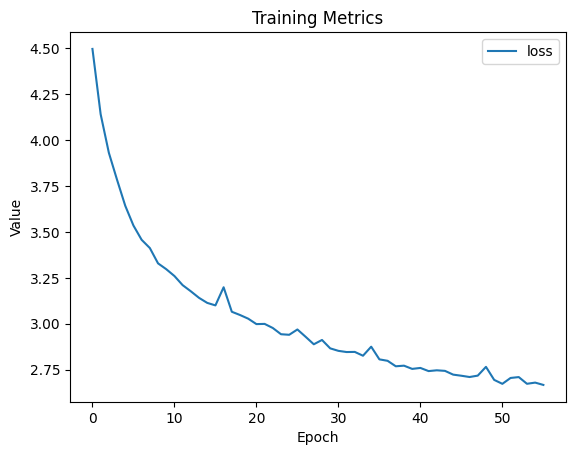

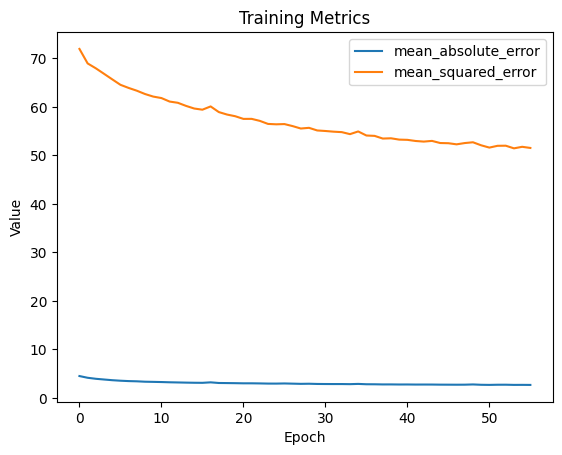

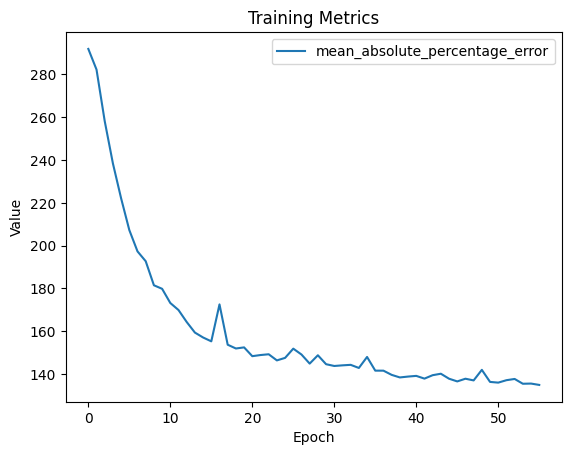

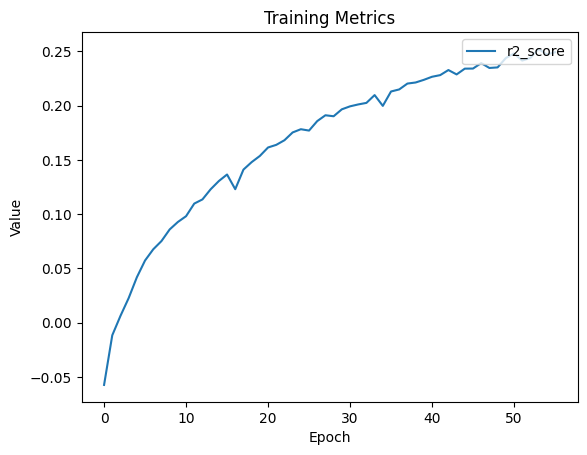

In [8]:
#Scores_IMF = []
dataset = pd.read_csv('/content/drive/Shareddrives/1st Paper/2nd.csv', header = 0, infer_datetime_format=True, index_col=['Date Time'])
#dataset = dataset[:-8438]
# set the base name of the file
base_filename = '/content/drive/Shareddrives/1st Paper/Performance/S11_best_model_ssa_VWC'

for m in range(0, 3):

  sc = ([0, 0, 0, 0], 0, 0, 0, 0, 0)
  print('IMF: ', m)
  data = pd.DataFrame(ssa[m]).T
  data.columns = ['S11_Top_VWC_Avg','Rain','S11_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']
  #testing = data[-8438:]
  #data = data[:-8438] 
  data = data

  %time
  External = data[['Rain','S11_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']]
  Predicted = data[['S11_Top_VWC_Avg']]
  index = pd.DataFrame(dataset.index)
  
  scaler = StandardScaler()
  scaler.fit(External)
  print('Scale_:', scaler.scale_)
    
  var = pd.DataFrame(scaler.transform(External))

  #var = data
  df = pd.concat([index, data['S11_Top_VWC_Avg'], var], axis = 1)
  df = df.set_index('Date Time')
  df.columns = ['S11_Top_VWC_Avg','Rain','S11_Top_Temp_Avg','Temp', 'Relative Humidity',
                  'Wind Speed', 'Solar Radiation']
  df_s = df


  
  # create the study
  study = optuna.create_study(direction='minimize', storage='sqlite:///example.db')

  # start the optimization
  study.optimize(objective, n_trials=3)

  # retrieve the best hyperparameters
  best_params = study.best_params
  print('Best hyperparameters:', best_params)

  train, test = split_dataset(df.values)

  # train the model using the best hyperparameters on the entire training set
  model = build_model(train, (best_params['n_input'], best_params['n_nodes'], best_params['n_epochs'], best_params['n_batch']), verbose=True)

  # set the filename based on the unique identifier
  filename = f"{base_filename}_{m}.h5"

  # save the model to a file
  model.save(filename)